In [1]:
import os
print(os.getcwd())

import sys
sys.path.append('/home/saraiva/Documentos/GitHub/data-science-analytics/utils')
from my_tools import custom_inspect_class
from my_tools import unpack_list

from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import tqdm
import time
import random
import matplotlib.pyplot as plt

#Regression Algorithms
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor as XGBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Classifier Algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

#Clustering Algorithms
from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering

#Regression Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

#Classification Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import auc

#Clustering Metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

from sklearn.datasets import load_boston
from pprint import pprint


X,y = load_boston(True)
data_columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df = pd.DataFrame(pd.concat([pd.DataFrame(X),pd.Series(y)],axis=1).values,
                            columns = data_columns)


/home/saraiva/Documentos/GitHub/data-science-analytics/notebooks


In [2]:
method_dict_regression ={
         
           'algo': 
                   {
                    AdaBoostRegressor.__name__ : AdaBoostRegressor,
                    BaggingRegressor.__name__ : BaggingRegressor,
                    GradientBoostingRegressor.__name__ : GradientBoostingRegressor,
                    RandomForestRegressor.__name__ : RandomForestRegressor ,
                    XGBoostRegressor.__name__ : XGBoostRegressor,
                   },                           
          
          'eval_metric' : 
                                 [mean_absolute_error,
                                  mean_squared_error,                                  
                                  mean_squared_log_error,],
                        
          'space' : 
                      {
                       AdaBoostRegressor.__name__ : {},
                       BaggingRegressor.__name__ : {},
                       GradientBoostingRegressor.__name__ : {}, 
                       RandomForestRegressor.__name__ :
                                                    { 
                                                      'bootstrap' :[True,False], 
                                                      'max_depth' : list(range(2, 10)),
                                                      'max_features' : ['auto','sqrt','log2'],
                                                      'min_samples_leaf': list(range(5,20)), 
                                                      'n_estimators': list(range(30, 300 ,5))
                                                    },
                       
                      XGBoostRegressor.__name__ : {},                                            
                      }           
                    
        }

In [3]:
class AutomatedRegression():
    
    def __init__(self,method_dict,main_metric):
        self.method_dict = method_dict
        self.metric_list = method_dict['eval_metric']
        self.main_metric = main_metric
        
    def pretty_print(self):
        '''Method to pprint some information
        First - Information about the method_dict whict dictionary possess'''
        pprint(self.method_dict)
        
    def fit_predict_tune(self,X,y,
                         choosen_algo,
                         number_splits = 5,
                         iterations = 20):
        ''' 
        This method is used to get the best hyperparameters for a given algorithm(choosen_algo) for regression 
        using Random Search.
        The space of search is given by the dictionary used for inicialization and the result dataframe contains 
        columns about the parameters used in the round and the mean obtained for the evaluation metrics.
        
        - Input :
        X : DataFrame - Exogenous Variables
        y : DataFrame - Endogenous Variables
        choosen_algo : Str - Algorithm's name, it's necessary to have the algorithm class specified in method_dict
        number_splits : Int - Number of splits in KFold
        iterations : Number of iterations of Random Search
        '''
        
        self.choosen_algo = choosen_algo
        param_grid = self.method_dict['space'][choosen_algo]
        
        param_col = [key for key in param_grid.keys()] + [metrics.__name__ for metrics in self.metric_list] + [self.main_metric.__name__ + '_train']
        
        lots_vals = list()
        print(choosen_algo)
        for rounds in tqdm.tqdm_notebook(range(iterations)):
            #Aleatoriza os parametros
            params = { key : random.sample(value,1)[0] for key,value in param_grid.items()}

            kf = KFold(n_splits = number_splits,shuffle = True)
            matrix_metrics = []
            counter = 1
            
            for train_idx,test_idx in kf.split(X):

                X_train,X_test = X.loc[train_idx,:],X.loc[test_idx,:]
                y_train,y_test = y.loc[train_idx,:],y.loc[test_idx,:]

                new_algo = self.method_dict['algo'][choosen_algo](**params)

                new_algo.fit(X_train,np.ravel(y_train))
                y_pred = new_algo.predict(X_test)
                y_pred_train = new_algo.predict(X_train)
                
                evaluation_list = []
                for evaluations in self.metric_list:
                    result = evaluations(y_test,y_pred)
                    evaluation_list.append(result)
                evaluation_list.append(self.main_metric(y_train,y_pred_train))
                matrix_metrics.append(evaluation_list)
                
                
            #Dataframe criado com os resultados das metricas em cada fold
            fold_dataframe = pd.DataFrame(matrix_metrics,
                                          columns = [metrics.__name__ for metrics in self.metric_list] +
                                                     [self.main_metric.__name__ + '_train'])

            # Return list of results
            metrics_results = fold_dataframe.mean().tolist()
            vals = list(params.values()) + metrics_results
            lots_vals.append(vals)
            
            self.result_dataframe = pd.DataFrame(lots_vals,columns = param_col)
            self.result_dataframe['choosen_algo'] = choosen_algo
        
        #if(report == True):
        
        return self.result_dataframe
    
    def reports(self):
        '''
        To run this method,it's necessary to pre-run fit_predict_tune.
        It displays the 5 Top Iterations in RandomSearch, display the describe about all runs and plot a
        histplot priorizing the main metric choosen by the user'''
        
        display(self.result_dataframe.sort_values(by = self.main_metric.__name__).head(5))
        self.desc_results = self.result_dataframe.describe()
        display(self.result_dataframe.describe())
        
        print("The mean of the main metric is : {}".
              format(self.desc_results.loc['mean'][self.main_metric.__name__]))
        print("The median of the main metric is : {}".
              format(self.desc_results.loc['50%'][self.main_metric.__name__]))
        print("The standard deviation of the main metric is : {}".
              format(self.desc_results.loc['std'][self.main_metric.__name__]))
        print('Mean + 3*sigma : {}'.
              format(self.desc_results.loc['mean'][self.main_metric.__name__] + 
                     3*self.desc_results.loc['std'][self.main_metric.__name__]))
        print('Mean - 3*sigma : {}'.
              format(self.desc_results.loc['mean'][self.main_metric.__name__] -
                     3*self.desc_results.loc['std'][self.main_metric.__name__]))
        print("The amplitude of the main metric is : {}".
              format(self.desc_results.loc['max'][self.main_metric.__name__] -
                     self.desc_results.loc['min'][self.main_metric.__name__]))

        plt.figure(figsize=(10,7))
        
        kwargs = dict(histtype='stepfilled', alpha=0.8, ec="k")

        plt.hist(self.result_dataframe[str(self.main_metric.__name__)],
                 align='mid',
                 density = True,
                 stacked = True,
                 **kwargs)
        
        plt.xlabel(self.main_metric.__name__)
        plt.ylabel('Probability')
        plt.title('Histogram - {}'.format(self.choosen_algo))
        plt.grid(True)
        plt.show()
    
    def info_full_reports(self, X, y, iter_report, number_splits):
        
        self.X_EXOGENOUS = X
        self.Y_ENDOGENOUS = y
        self.ITER_REPORT = iter_report
        self.NUM_SPLITS = number_splits
        
    def auto_full_reports(self):
        
        for alg in self.method_dict['algo'].keys():
            temp_ar = AutomatedRegression(method_dict= self.method_dict,
                                         main_metric = self.main_metric)
            
            temp_ar.fit_predict_tune(X = pd.DataFrame(self.X_EXOGENOUS),
                                     y = pd.DataFrame(self.Y_ENDOGENOUS),
                                     choosen_algo = alg,
                                     number_splits = self.NUM_SPLITS,
                                     iterations = self.ITER_REPORT)
            temp_ar.reports()

AdaBoostRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,mean_squared_error_train,choosen_algo
161,2.650756,12.340986,0.030144,7.960980,AdaBoostRegressor
146,2.663174,12.386226,0.029635,8.044178,AdaBoostRegressor
116,2.700901,12.629280,0.030415,7.935879,AdaBoostRegressor
39,2.717202,12.694925,0.030778,7.980337,AdaBoostRegressor
152,2.734560,12.784454,0.031188,8.117455,AdaBoostRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,mean_squared_error_train
count,200.000000,200.000000,200.000000,200.000000
mean,2.766196,13.886477,0.032111,8.059945
std,0.039162,0.713454,0.000937,0.080224
min,2.650756,12.340986,0.029635,7.806867
25%,2.737814,13.412826,0.031494,8.004835
50%,2.767332,13.812964,0.031958,8.057825
75%,2.792689,14.273386,0.032615,8.121715
max,2.866085,16.109856,0.035285,8.247614


The mean of the main metric is : 13.88647672957045
The median of the main metric is : 13.812964078392753
The standard deviation of the main metric is : 0.7134539831706209
Mean + 3*sigma : 16.026838679082314
Mean - 3*sigma : 11.746114780058587
The amplitude of the main metric is : 3.7688704879867565


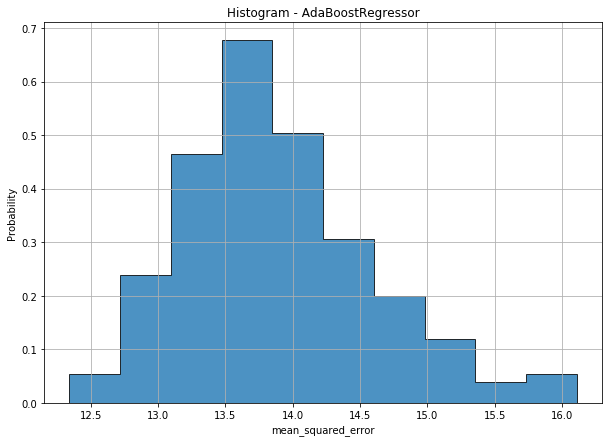

BaggingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,mean_squared_error_train,choosen_algo
95,2.146258,9.492039,0.019759,2.096481,BaggingRegressor
89,2.197567,9.652955,0.020177,2.090370,BaggingRegressor
193,2.210032,9.698053,0.020658,2.222519,BaggingRegressor
196,2.180591,10.006169,0.021143,2.071588,BaggingRegressor
2,2.209920,10.014109,0.021076,2.178822,BaggingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,mean_squared_error_train
count,200.000000,200.000000,200.000000,200.000000
mean,2.302871,11.781938,0.023010,2.134102
std,0.055925,0.958451,0.001265,0.074778
min,2.146258,9.492039,0.019759,1.964882
25%,2.268004,11.086466,0.022209,2.080801
50%,2.306532,11.651581,0.022882,2.130896
75%,2.337575,12.388354,0.023989,2.179258
max,2.437199,14.411669,0.026068,2.341051


The mean of the main metric is : 11.78193789553846
The median of the main metric is : 11.651581338461538
The standard deviation of the main metric is : 0.9584514328464177
Mean + 3*sigma : 14.657292194077714
Mean - 3*sigma : 8.906583596999207
The amplitude of the main metric is : 4.9196294923076955


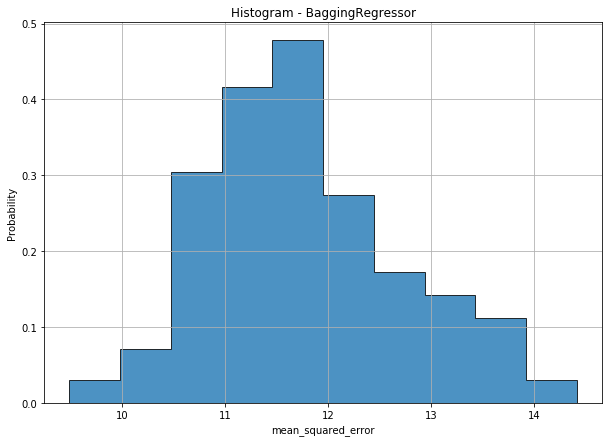

GradientBoostingRegressor


In [ ]:
zzz = AutomatedRegression(method_dict_regression,mean_squared_error)
zzz.info_full_reports(X,y,200,20)
zzz.auto_full_reports()